In [ ]:
### Market Data Analysis
#Vishala vemuri | Megha Chandrasekharan Nair | Mallikarjun Gudumagatte Nagaraja

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("Security exchange Analysis").master("spark://primary:7077").getOrCreate()

25/04/27 15:19:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
df = spark.read.csv("hdfs://primary:9000/user/xploit/input/SecurityExchange2024.csv",header=True,inferSchema=True)

In [ ]:
df.show(5)  # View first 5 rows

+--------+--------+------+--------+--------+--------+--------------+---------+-------+------+---------+-------+------+---------------+--------------+--------------+------------------+------------------+------------------+-----------------------+
|    Date|Security|Ticker|Exchange|McapRank|TurnRank|VolatilityRank|PriceRank|Cancels|Trades|LitTrades|OddLots|Hidden|TradesForHidden|OrderVol('000)|TradeVol('000)|      LitVol('000)|   OddLotVol('000)|   HiddenVol('000)|TradeVolForHidden('000)|
+--------+--------+------+--------+--------+--------+--------------+---------+-------+------+---------+-------+------+---------------+--------------+--------------+------------------+------------------+------------------+-----------------------+
|20240401|   Stock|     A|    Amex|    10.0|     3.0|           1.0|     10.0|10170.0|  22.0|     20.0|   19.0|   2.0|           22.0|       3863.62|         0.512|0.3829999999999999|             0.212|             0.129|                  0.512|
|20240401|   Sto

In [ ]:
#Basic Row and Column Counts
print(f"Total Rows: {df.count()}")
print(f"Total Columns: {len(df.columns)}")


Total Rows: 25140855
Total Columns: 20


In [ ]:
#Rename Columns
df = df.withColumnRenamed("OrderVol('000)", "OrderVol") \
       .withColumnRenamed("TradeVol('000)", "TradeVol") \
       .withColumnRenamed("LitVol('000)", "LitVol") \
       .withColumnRenamed("OddLotVol('000)", "OddLotVol") \
       .withColumnRenamed("HiddenVol('000)", "HiddenVol") \
       .withColumnRenamed("TradeVolForHidden('000)", "TradeVolForHidden")


In [ ]:
#Missing Value Check
from pyspark.sql.functions import col
df.select([col(c).isNull().alias(c) for c in df.columns]).groupBy().sum().show()


++
||
++
||
++



In [ ]:
#Basic Statistics
numeric_cols = ['McapRank', 'TurnRank', 'VolatilityRank', 'PriceRank',
                'Cancels', 'Trades', 'LitTrades', 'OddLots', 'Hidden', 'TradesForHidden',
                'OrderVol', 'TradeVol', 'LitVol', 'OddLotVol', 'HiddenVol', 'TradeVolForHidden']
df.select(numeric_cols).describe().show()


25/04/27 15:20:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+------------------+
|summary|         McapRank|          TurnRank|    VolatilityRank|         PriceRank|           Cancels|            Trades|         LitTrades|           OddLots|           Hidden|  TradesForHidden|         OrderVol|        TradeVol|            LitVol|        OddLotVol|        HiddenVol| TradeVolForHidden|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+------------------+
|  count|         25140290|          25140275|          25140182|          2514029

In [ ]:
#Unique Counts
df.select("Security").distinct().count()
df.select("Ticker").distinct().count()
df.select("Exchange").distinct().show()


+--------+
|Exchange|
+--------+
|     IEX|
|  Edge-A|
|     NSX|
|    NYSE|
|    Arca|
|  Nasdaq|
|    MEMX|
|    MIAX|
|    Amex|
|  Edge-X|
|     CHX|
|  Bats-Z|
|    Phlx|
|  Bats-Y|
|  Boston|
+--------+



In [ ]:
#Check Date Range
df.selectExpr("min(Date)", "max(Date)").show()

+---------+---------+
|min(Date)|max(Date)|
+---------+---------+
| 20240102| 20241231|
+---------+---------+



In [ ]:
#Top Entities
#Most Active Stocks by Trades
df.groupBy("Ticker").sum("Trades").orderBy("sum(Trades)", ascending=False).show(10)


+------+------------+
|Ticker| sum(Trades)|
+------+------------+
|  NVDA|1.64405423E8|
|  TSLA|1.16395266E8|
|  SOXL| 7.3844853E7|
|  AAPL| 7.2005828E7|
|   SPY| 7.1551106E7|
|   AMD| 6.1968565E7|
|  AMZN| 5.4455154E7|
|   QQQ| 5.2208405E7|
| GOOGL| 4.8428148E7|
|  TQQQ| 4.4774721E7|
+------+------------+
only showing top 10 rows



In [ ]:
#Most Active Exchanges by Trade Volume
df.groupBy("Exchange").sum("TradeVol").orderBy("sum(TradeVol)", ascending=False).show(10)

+--------+--------------------+
|Exchange|       sum(TradeVol)|
+--------+--------------------+
|  Nasdaq|2.6767590072399512E8|
|    Arca| 1.671439571229991E8|
|    NYSE|1.0915784516900001E8|
|  Edge-X|1.0143294957700078E8|
|  Bats-Z|  9.01092699950021E7|
|     IEX| 5.031204008300146E7|
|    MEMX|4.9635010751001395E7|
|    MIAX| 3.769538887100038E7|
|  Edge-A|2.6495409946000036E7|
|  Bats-Y| 1.677221122399942E7|
+--------+--------------------+
only showing top 10 rows



In [ ]:
#Basic Visualizations (using Matplotlib/Seaborn)
#Convert Small Sample to Pandas
sample_df = df.select("Exchange", "TradeVol", "OddLotVol", "HiddenVol").sample(0.1).toPandas()

/home/megha/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


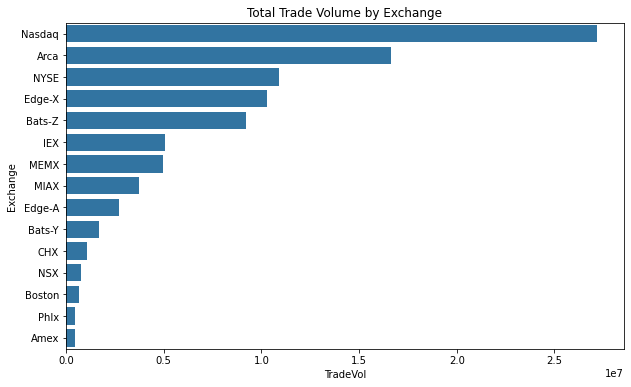

In [ ]:
#Trade Volume per Exchange
import matplotlib.pyplot as plt
import seaborn as sns

exchange_vol = sample_df.groupby('Exchange').sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="TradeVol", y="Exchange", data=exchange_vol.sort_values("TradeVol", ascending=False))
plt.title("Total Trade Volume by Exchange")
plt.show()


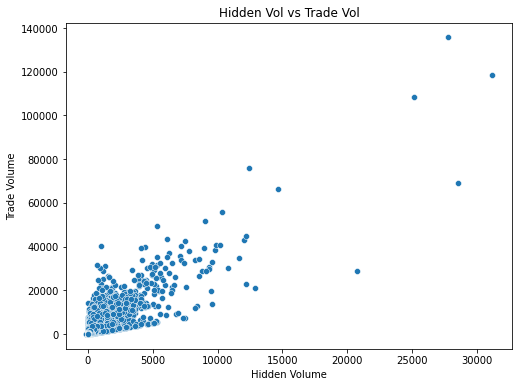

In [ ]:
#Hidden Volume vs Lit Volume
plt.figure(figsize=(8,6))
sns.scatterplot(x="HiddenVol", y="TradeVol", data=sample_df)
plt.title("Hidden Vol vs Trade Vol")
plt.xlabel("Hidden Volume")
plt.ylabel("Trade Volume")
plt.show()


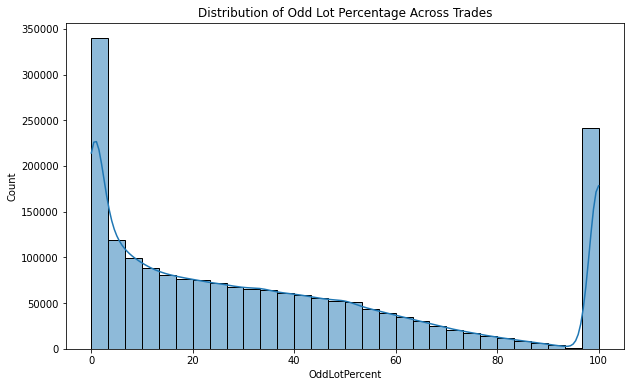

In [ ]:
#Odd Lot Volume % of Total Trade
sample_df['OddLotPercent'] = (sample_df['OddLotVol'] / sample_df['TradeVol']) * 100

plt.figure(figsize=(10,6))
sns.histplot(sample_df['OddLotPercent'], bins=30, kde=True)
plt.title("Distribution of Odd Lot Percentage Across Trades")
plt.show()


In [ ]:
#Q1. Are high volatility stocks traded more through hidden orders than regular (lit) ones?
from pyspark.sql.functions import col, when, sum, avg, round

# Step 1: Create a new column for hidden trade proportion
df = df.withColumn("HiddenRatio",
                   when(col("TradeVol") > 0,
                        col("HiddenVol") / col("TradeVol"))
                   .otherwise(0))

# Step 2: Filter for only high volatility stocks (say, top 25%)
vol_threshold = df.approxQuantile("VolatilityRank", [0.25], 0.01)[0]
high_vol_df = df.filter(col("VolatilityRank") <= vol_threshold)

# Step 3: Group by Ticker and get average HiddenRatio
result = high_vol_df.groupBy("Ticker").agg(
    round(avg("HiddenRatio"), 3).alias("AvgHiddenTradeRatio")
).orderBy(col("AvgHiddenTradeRatio").desc())

result.show()

+------+-------------------+
|Ticker|AvgHiddenTradeRatio|
+------+-------------------+
|  DECM|              0.766|
|  HYZN|              0.733|
|  VCRM|              0.704|
|  SOND|               0.68|
|  HELO|              0.669|
|  DFGX|              0.656|
|  DGCB|              0.645|
|  AVSC|              0.618|
|  CRMT|              0.617|
|  RDVI|              0.614|
|  RECS|              0.599|
|  IWMI|              0.598|
|  HAUZ|              0.586|
|  SPRE|              0.584|
|  VCRB|              0.583|
|  QQQI|              0.581|
|  SMBS|              0.579|
|  FMHI|              0.578|
|   DDS|              0.578|
|  DIPS|              0.578|
+------+-------------------+
only showing top 20 rows



In [ ]:
#Q2. Are high cancellation days followed by high trade volumes for the same stock (i.e., is there “prep” before action)?
from pyspark.sql.functions import lag, col, when, sum as _sum, count, round
from pyspark.sql.window import Window

# Step 1: Sort data for window function
window = Window.partitionBy("Ticker").orderBy("Date")

# Step 2: Shift cancellation data by one day
df = df.withColumn("PrevDayCancels", lag("Cancels").over(window))

# Step 3: Calculate if high cancels are followed by high trades
df = df.withColumn("TradeVolHigh", when(col("TradeVol") > 1000, 1).otherwise(0)) \
       .withColumn("HighCancelToTrade",
                   when((col("PrevDayCancels") > 100) & (col("TradeVolHigh") == 1), 1).otherwise(0))

# Step 4: Check ratio of such occurrences per ticker
summary = df.groupBy("Ticker").agg(
    sum("HighCancelToTrade").alias("Occurrences"),
    count("Date").alias("TotalDays")
).withColumn("TriggerRate", round(col("Occurrences") / col("TotalDays"), 2)) \
 .orderBy("TriggerRate", ascending=False)

summary.show()

25/04/27 16:03:31 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/04/27 16:03:33 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.


+------+-----------+---------+-----------+
|Ticker|Occurrences|TotalDays|TriggerRate|
+------+-----------+---------+-----------+
|  SQQQ|       2160|     3780|       0.57|
|   XLF|       1836|     3780|       0.49|
|     F|       1600|     3780|       0.42|
|  NVDA|       1539|     3780|       0.41|
|   FXI|       1510|     3780|        0.4|
|   SPY|       1498|     3780|        0.4|
|  SOXS|       1509|     3780|        0.4|
|   HYG|       1457|     3780|       0.39|
|  TQQQ|       1433|     3780|       0.38|
|  INTC|       1396|     3780|       0.37|
|  SPXS|       1389|     3780|       0.37|
|  PLTR|       1354|     3780|       0.36|
|   TLT|       1369|     3780|       0.36|
|  PLUG|       1317|     3780|       0.35|
|  SOFI|       1323|     3780|       0.35|
|  SOXL|       1335|     3780|       0.35|
|   EEM|       1296|     3780|       0.34|
|   BAC|       1281|     3780|       0.34|
|   IWM|       1242|     3780|       0.33|
|   QQQ|       1255|     3780|       0.33|
+------+---

In [ ]:
#Q3. What percentage of trades in an exchange come from odd lots, and is that increasing over time?
from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws, year, month, to_date, sum as _sum, col, round
from pyspark.sql.window import Window

# ----------------------------------------
# Step 1: Fix the Date Column
# ----------------------------------------
# Convert integer Date to Proper DateType
df = df.withColumn("DateString", F.col("Date").cast("string")) \
       .withColumn("ProperDate", to_date(F.col("DateString"), "yyyyMMdd"))

# Create YearMonth column
df = df.withColumn("YearMonth", concat_ws("-", year("ProperDate"), month("ProperDate")))

# ----------------------------------------
# Step 2: Group by Exchange and YearMonth
# ----------------------------------------
summary = df.groupBy("Exchange", "YearMonth").agg(
    round(_sum(col("OddLotVol")),2).alias("TotalOddLotVol"),
    round(_sum(col("TradeVol")),2).alias("TotalTradeVol")
)

# ----------------------------------------
# Step 3: Compute Odd Lot Proportion
# ----------------------------------------
summary = summary.withColumn(
    "OddLotRatio",
    round(col("TotalOddLotVol") / col("TotalTradeVol"), 4)
)

# ----------------------------------------
# Step 4: Sort and Display Trend
# ----------------------------------------
summary.orderBy("Exchange", "YearMonth").show(30)


+--------+---------+--------------+-------------+-----------+
|Exchange|YearMonth|TotalOddLotVol|TotalTradeVol|OddLotRatio|
+--------+---------+--------------+-------------+-----------+
|    Amex|   2024-1|      39249.19|    376366.51|     0.1043|
|    Amex|  2024-10|      34184.38|    327054.83|     0.1045|
|    Amex|  2024-11|      33332.44|    356477.19|     0.0935|
|    Amex|  2024-12|      32805.73|    383468.14|     0.0856|
|    Amex|   2024-2|      41193.37|     365067.3|     0.1128|
|    Amex|   2024-3|      34317.03|    360847.87|     0.0951|
|    Amex|   2024-4|      41224.47|    418937.56|     0.0984|
|    Amex|   2024-5|      38908.09|    394517.89|     0.0986|
|    Amex|   2024-6|       34818.8|    350717.41|     0.0993|
|    Amex|   2024-7|      37265.65|    386435.15|     0.0964|
|    Amex|   2024-8|      42446.07|    377216.85|     0.1125|
|    Amex|   2024-9|       36333.1|    319223.08|     0.1138|
|    Arca|   2024-1|    1377143.34| 1.37387831E7|     0.1002|
|    Arc